## Predict the demand for bike share using known tools

Our goal is to predict demand for bike share based on [this](https://www.kaggle.com/c/bike-sharing-demand) Kaggle task.
Kaggle provides two data sets: a labelled train data and an unlabelled test data.
We have to use the train data to predict labels for the test data.
Kaggle won't give us the labels just a score we achieved on the test set.

### Know your data

In [2]:
import pandas as pd
import numpy as np

bike_data = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/bike_sample.csv")

In [2]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-10-18T03:00:00Z,4,0,1,1,18.04,21.970,94,6.0032,0,1,1
1,2011-08-17T21:00:00Z,3,0,1,1,29.52,34.090,62,15.0013,38,192,230
2,2012-11-11T11:00:00Z,4,0,0,1,18.86,22.725,59,8.9981,180,324,504
3,2011-05-12T16:00:00Z,2,0,1,2,26.24,31.060,57,16.9979,50,238,288
4,2011-05-04T15:00:00Z,2,0,1,1,19.68,23.485,51,27.9993,22,107,129


In [3]:
bike_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000
mean,2.536518,0.028939,0.684887,1.434084,20.249518,23.611169,62.011024,13.021061,36.555351,155.788700,192.344051
std,1.120364,0.167673,0.464667,0.642688,7.786268,8.444582,19.285464,8.150234,51.005170,151.047109,181.463651
min,1.000000,0.000000,0.000000,1.000000,0.820000,2.275000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,37.000000,44.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.000000,120.000000,147.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,224.000000,284.000000
max,4.000000,1.000000,1.000000,3.000000,41.000000,43.940000,100.000000,47.998800,362.000000,886.000000,977.000000


In [4]:
bike_data.shape

(2177, 12)

In [5]:
bike_data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

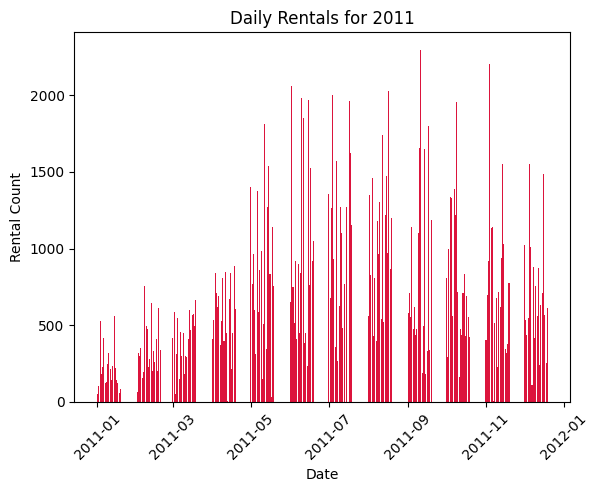

In [6]:
import matplotlib.pyplot as plt
bike_data["datetime"] = pd.to_datetime(bike_data["datetime"])
bike_2011 = bike_data[bike_data["datetime"].dt.year == 2011]
daily_counts = bike_2011.groupby(bike_2011["datetime"].dt.date)["count"].sum()
dates = daily_counts.index
counts = daily_counts.values

plt.bar(dates, counts, color="crimson")
plt.xlabel("Date")
plt.ylabel("Rental Count")
plt.title("Daily Rentals for 2011")
plt.xticks(rotation=45)
plt.show()

### Train-test split

In [7]:
# train-validation split on numeric features
from sklearn.model_selection import train_test_split

# keep numeric features
features = bike_data.drop(columns=["count"]).select_dtypes(include=np.number)
label = bike_data["count"]
np.random.seed(20240306)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

### Technical detour: best practice for pseudo random number generation and ensuring reproducibility

We used to ensure reproducibility by setting the global seed with `np.random.seed()`.

This is a risky practice as it modifies the global state. Some imported packages and functions may be unintentionally affected.

The recommended practice instead is to create a new (psuedo) random number generator and pass it around.
Call `np.random.RandomState(<seed>)` to create a new RNG.
(For numpy 1.17+, there is a statistically better alternative: `np.random.default_rng(<seed>)`. However, not all packages are already updated to accept that class as a random state.)

See more details [here](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

In [8]:
prng = np.random.RandomState(20240306)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)

### Evaluation function

In [9]:
# define loss function
def calculateRMSLE(prediction, y_obs):
    return np.sqrt(
        np.mean(
            (
                np.log(np.where(prediction < 0, 0, prediction) + 1) -
                np.log(y_obs + 1)
            )**2
        )
    )

### Benchmark

In [10]:
# estimate benchmark model
benchmark = np.mean(y_train)
benchmark_result = ["Benchmark", calculateRMSLE(benchmark, y_train), calculateRMSLE(benchmark, y_test)]

In [11]:
# collect results into a DataFrame
result_columns = ["Model", "Train", "Test"]
pd.DataFrame([benchmark_result], columns=result_columns)

,Model,Train,Test
0,Benchmark,1.561443,1.560975


### Model #1: Group averages

#### Statistics recap: linear regression and averages

If you fit a linear regression model using a dummy variable without any other features, the model will predict the average outcome for the groups represented by the dummy variables. A binary variable with numeric values 0 and 1 behaves as a dummy variable without any further transformation. The estimated intercept of the linear regression captures the average of the reference category (for which the binary variable takes the value of 0) while the coefficient expressed the difference between the averages of the categories.

In [12]:
# illustration on a single binary variable
from sklearn.linear_model import LinearRegression

lin_reg_simple_dummy = LinearRegression().fit(X_train[["holiday"]], y_train)
prediction = lin_reg_simple_dummy.predict(X_train[["holiday"]])

joint_data = pd.DataFrame({
    "dummy": X_train[["holiday"]].values.flatten(),
    "y": y_train,
    "prediction": prediction
})
joint_data["group_avg"] = joint_data.groupby("dummy")["y"].transform("mean")
joint_data[["dummy", "prediction", "group_avg"]].drop_duplicates()

,dummy,prediction,group_avg
251,0,193.360190,193.360190
28,1,208.471698,208.471698


In [13]:
# Compare it to estimated coefficients
[lin_reg_simple_dummy.intercept_, lin_reg_simple_dummy.intercept_ + lin_reg_simple_dummy.coef_[0]]

[193.3601895734597, 208.47169811320754]

For categorical variables with multiple categories, we have to ensure to represent each category level by a dummy variable (called one-hot encoding achieved by `pd.get_dummies()` or `OneHotEncoder`).
To avoid multicollinearity issues, you need to omit one of the dummy variables. Including all of them in the model would lead to redundant information because the value of one dummy variable can be predicted from the values of the other dummy variables. By omitting one dummy variable, you set it as the reference category, and the coefficients of the remaining dummy variables represent the difference in the outcome variable between each category and the reference category. With the constant term, you estimate as many coefficients as there are category levels.

In [14]:
# illustration on a multi-level categorical variable
feature_matrix_categorical = pd.get_dummies(X_train[["season"]], columns=["season"], drop_first=True)
feature_matrix_columns = feature_matrix_categorical.columns.to_list()

lin_reg_categorical = LinearRegression().fit(feature_matrix_categorical, y_train)
prediction = lin_reg_categorical.predict(feature_matrix_categorical)

joint_data = pd.concat([
    feature_matrix_categorical.reset_index(drop=True),
    pd.DataFrame({
        "prediction": lin_reg_categorical.predict(feature_matrix_categorical),
        "y": y_train.reset_index(drop=True)
    }),
], axis=1)

joint_data["group_avg"] = joint_data.groupby(feature_matrix_columns)["y"].transform("mean")
joint_data.drop("y", axis=1).drop_duplicates().sort_values(feature_matrix_columns)

,season_2,season_3,season_4,prediction,group_avg
2,False,False,False,114.484487,114.484487
0,False,False,True,210.762419,210.762419
14,False,True,False,231.262411,231.262411
5,True,False,False,215.745413,215.745413


In [15]:
# Compare it to estimated coefficients
[lin_reg_categorical.intercept_] + [lin_reg_categorical.intercept_ + coef for coef in lin_reg_categorical.coef_]

[114.48448687350833, 215.74541284403688, 231.2624113475176, 210.76241900647943]

If you have multiple categorical variables, life gets complicated. To ensure that you estimate as many coefficients as there are combinations of categories to capture the average of each group, we also need to include the _interaction_ of the dummies. You can achieve this with `PolynomialFeatures`. However, if some of your categorical variables are multilevel, the interaction of these dummies within the same category (e.g. `season_2 * season_3`) will be constant zero, and you will get a linearly-dependent (rank-deficient) feature matrix. The optimization algorithm of the `LinearRegression` will give you a solution anyway (see [this](https://stats.stackexchange.com/a/473189/86780) answer about details of the algorithm - other implemantions choose another strategy, like `lm()` in R which automatically drops these features). To avoid such situation, we need to exclude variables with zero variance with `VarianceThreshold` (which defaults to the threshold of zero variance).

In [16]:
# Illustration on multiple categorical variables

# construct feature matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold

feature_matrix_multiple_categories = pd.get_dummies(X_train[["season", "workingday"]], columns=["season", "workingday"], drop_first=True)
feature_matrix_columns = feature_matrix_multiple_categories.columns.to_list()

create_interactions = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
feature_matrix_multiple_categories_interactions = create_interactions.fit_transform(feature_matrix_multiple_categories)
create_interactions.get_feature_names_out()

drop_no_variance = VarianceThreshold()
feature_matrix_relevant_interactions = drop_no_variance.fit_transform(feature_matrix_multiple_categories_interactions)
feature_matrix_relevant_interactions.shape  # 4*2 levels (one dropped as a reference)

(1741, 7)

In [17]:
# get group average predictions
lin_reg_multiple_categories = LinearRegression().fit(feature_matrix_relevant_interactions, y_train)

joint_data = pd.concat([
    feature_matrix_multiple_categories.reset_index(drop=True),
    pd.DataFrame({
        "prediction": lin_reg_multiple_categories.predict(feature_matrix_relevant_interactions),
        "y": y_train.reset_index(drop=True)
    }),
], axis=1)

joint_data["group_avg"] = joint_data.groupby(feature_matrix_columns)["y"].transform("mean")
joint_data.drop("y", axis=1).drop_duplicates().sort_values(feature_matrix_columns)

,season_2,season_3,season_4,workingday_1,prediction,group_avg
19,False,False,False,False,107.594828,107.594828
2,False,False,False,True,117.122112,117.122112
64,False,False,True,False,204.060811,204.060811
0,False,False,True,True,213.911111,213.911111
26,False,True,False,False,241.000000,241.000000
14,False,True,False,True,226.445230,226.445230
5,True,False,False,False,230.115942,230.115942
6,True,False,False,True,209.090604,209.090604


In [18]:
# Compare it to estimated coefficients
[lin_reg_multiple_categories.intercept_] + [lin_reg_multiple_categories.intercept_ + coef for coef in lin_reg_multiple_categories.coef_]

[107.5948275862068,
 230.11594202898561,
 240.99999999999974,
 204.06081081081078,
 117.12211221122126,
 77.04220495905251,
 83.51277264317119,
 107.91784326149266]

It indeed predicts group averages.

#### Technical detour: Using Pipelines from scikit-learn

In order to evaluate our model on a new data set, we have to apply the exact same transformations on that set as well (here: creating dummies, creating interactions, drop features with zero variance...). That gets cumbersome quicky. The scikit library offers a handy tool to make this easier: `Pipeline`. You have to define the whole pipeline only once; then you can apply it on any dataset. A `Pipeline` takes a list of steps, each step consisting of a two-element tuple: a name (you name it) and the operation itself.

If you want to apply specific transformations on some columns, you can use `ColumnTransformer`. A `ColumnTransformer` takes a list of transformation and some optional parameters (like what to do with the `remainder` columns that were not specified in the transformation steps; defaults to `"drop"`, change to `"passthrough"` if you want to keep them). Each transformation consists of a three-element tuple: a name (you name it), the operation, and the columns the operation needs to be applied (given by the list of name, indices, etc.).

While `Pipeline` executes the steps sequentially, `ColumnTransformer` applies the listed operations at once on different sets of columns.

See [this Medium post](https://towardsdatascience.com/simplifying-machine-learning-model-development-with-columntransformer-pipeline-f09ffb04ca6b) for a more detailed explanation.

Here we would like to apply multiple steps sequentially (`Pipeline`) on a specific set of the original columns in our training data (`ColumnTransformer`), so we will pass a `Pipeline` to the `ColumnTransformer`. Then, we we would like to estimate a model, so we build another `Pipeline` for the whole process.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

dummy_features = ["season", "workingday"]

one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")

create_categorical_features = Pipeline([
    ("dummify", one_hot_encoder),
    ("create_interactions", create_interactions),
    ("drop_zero_variance", drop_no_variance)
])

pipe_whole_process = Pipeline([
    ("create_features", ColumnTransformer([("choose_and_transform_features", create_categorical_features, dummy_features)])),
    ("ols", LinearRegression())
])
pipe_whole_process

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('choose_and_transform_features',
                                                  Pipeline(steps=[('dummify',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('create_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('drop_zero_variance',
                                                                   VarianceThreshold())]),
                                                  ['season', 'workingday'])])),
                ('ols', LinearRegression())])

In [20]:
pipe_whole_process.fit(X_train, y_train)

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('choose_and_transform_features',
                                                  Pipeline(steps=[('dummify',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('create_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('drop_zero_variance',
                                                                   VarianceThreshold())]),
                                                  ['season', 'workingday'])])),
                ('ols', LinearRegression())])

In [21]:
# Double-check we got the same result
(
    calculateRMSLE(lin_reg_multiple_categories.predict(feature_matrix_relevant_interactions), y_train),
    calculateRMSLE(pipe_whole_process.predict(X_train), y_train),
)

(1.5146146495189914, 1.5146146495189914)

#### Estimate model #1: group averages by weather, workingday and holiday

In [22]:
# estimate & evaluate model #1
dummy_features = ["season", "workingday", "holiday"]

steps = [
    ("create_features", ColumnTransformer([("choose_and_transform_features", create_categorical_features, dummy_features)])),
    ("ols", LinearRegression())
]

pipe_group_avg = Pipeline(steps)
pipe_group_avg.fit(X_train, y_train)


train_error = calculateRMSLE(pipe_group_avg.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_group_avg.predict(X_test), y_test)

group_avg_result = ["Group-avg", train_error, test_error]
group_avg_result

['Group-avg', 1.5134412770171357, 1.5095948284754475]

In [23]:
pd.DataFrame([benchmark_result, group_avg_result], columns=result_columns)

,Model,Train,Test
0,Benchmark,1.561443,1.560975
1,Group-avg,1.513441,1.509595


### Model #2: Group averages with weather

In [24]:
# Model #2: Group averages with weather
dummy_features = ['season', 'holiday', 'workingday', 'weather']
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed']

steps = [
    ("create_features", ColumnTransformer([
        ("choose_and_transform_dummy_features", create_categorical_features, dummy_features),
        ("keep_numeric_features", "passthrough", numeric_features)
    ])),
    ("ols", LinearRegression())
]

pipe_group_avg_with_weather = Pipeline(steps)
pipe_group_avg_with_weather.fit(X_train, y_train)

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('choose_and_transform_dummy_features',
                                                  Pipeline(steps=[('dummify',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('create_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('drop_zero_variance',
                                                                   VarianceThreshold())]),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('keep_numeric_features',
                                                  'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('ols', LinearRegression())])

In [25]:
group_avg_with_weather_result = [
    'Group avgs with weather',
    calculateRMSLE(pipe_group_avg_with_weather.predict(X_train), y_train),
    calculateRMSLE(pipe_group_avg_with_weather.predict(X_test), y_test)
]
results = pd.DataFrame(
    [benchmark_result, group_avg_result, group_avg_with_weather_result],
    columns=result_columns
)
results

,Model,Train,Test
0,Benchmark,1.561443,1.560975
1,Group-avg,1.513441,1.509595
2,Group avgs with weather,1.391927,1.394940


### Model #3: Very flexible linear with polynomial features

In [26]:
steps = [
    ("create_features", ColumnTransformer([
        ("create_dummy_features", one_hot_encoder, dummy_features), # we will create interactions later across all features
        ("keep_numeric_features", "passthrough", numeric_features)
    ])),
    ("4_degree_poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("drop_zero_variance", drop_no_variance),
    ("ols", LinearRegression())
]

pipe_flexible_linear = Pipeline(steps)
pipe_flexible_linear

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('create_dummy_features',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('keep_numeric_features',
                                                  'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('4_degree_poly',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('drop_zero_variance', VarianceThreshold()),
                ('ols', LinearRegression())])

In [27]:
pipe_flexible_linear.fit(X_train, y_train)
train_error = calculateRMSLE(pipe_flexible_linear.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_flexible_linear.predict(X_test), y_test)

flexible_linear_result = ['Flexible linear', train_error, test_error]

results.loc[len(results)] = flexible_linear_result
results

,Model,Train,Test
0,Benchmark,1.561443,1.560975
1,Group-avg,1.513441,1.509595
2,Group avgs with weather,1.391927,1.394940
3,Flexible linear,1.178133,1.759831


### Model #4: Improve with Lasso

In [28]:
# Model #4: improve with Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler

steps = [
    ("create_features", ColumnTransformer([
        ("create_dummy_features", one_hot_encoder, dummy_features),
        ("scale_numeric_features", MinMaxScaler(), numeric_features)
    ])),
    ("4_degree_poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("drop_zero_variance", drop_no_variance),
    ("lasso", LassoCV())
]
pipe_lasso = Pipeline(steps)

pipe_lasso.fit(X_train, y_train)

/Users/i525503/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5614.36004216969, tolerance: 4504.727965229886
  model = cd_fast.enet_coordinate_descent_gram(
/Users/i525503/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6905.431097839028, tolerance: 4504.727965229886
  model = cd_fast.enet_coordinate_descent_gram(
/Users/i525503/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4550.410112489015, tolerance: 4504.727965229886
  model = cd_fast.enet_coordinate_descent_gram(
/Users/i525503/.pyen

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('create_dummy_features',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('scale_numeric_features',
                                                  MinMaxScaler(),
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('4_degree_poly',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('drop_zero_variance', VarianceThreshold()),
                ('lasso', LassoCV())])

In [29]:
train_error = calculateRMSLE(pipe_lasso.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_lasso.predict(X_test), y_test)

lasso_model_result = ['Flexible LASSO', train_error, test_error]
results.loc[len(results)] = lasso_model_result
results

,Model,Train,Test
0,Benchmark,1.561443,1.560975
1,Group-avg,1.513441,1.509595
2,Group avgs with weather,1.391927,1.394940
3,Flexible linear,1.178133,1.759831
4,Flexible LASSO,1.305518,1.328260


**Lessons:**

- Gradually adding more information present in the training improves our models' performance.
- Being very flexible without any penalty for the complexity leads to overfitting (test error >> train error).
- Choosing a method with regularization (and tune the hyperparameter automatically by `LassoCV`) is able to exploit flexibility without overfitting - however, the performance gain of flexibility is small.

## Improve the models

### Diagnostics

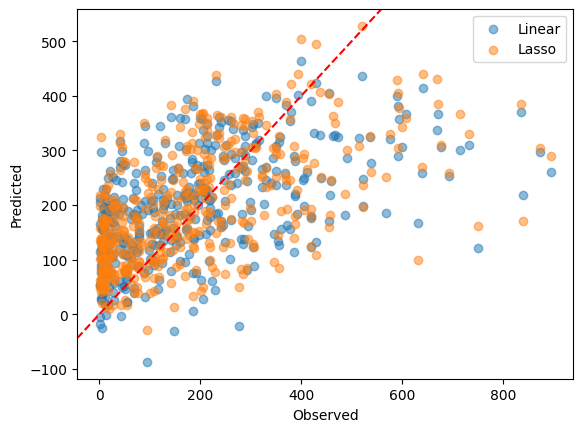

In [30]:
import matplotlib.pyplot as plt

linear_predictions = pipe_group_avg_with_weather.predict(X_test)
lasso_predictions = pipe_lasso.predict(X_test)

plt.scatter(y_test, linear_predictions, label='Linear', alpha=0.5)
plt.scatter(y_test, lasso_predictions, label='Lasso', alpha=0.5)
plt.axline((1, 1), slope=1, linestyle='dashed', color='red')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend()

In [31]:
bike_data[bike_data['count'] < 10]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-10-18 03:00:00+00:00,4,0,1,1,18.04,21.970,94,6.0032,0,1,1
15,2012-09-12 03:00:00+00:00,3,0,1,1,20.50,24.240,77,6.0032,0,7,7
16,2011-01-06 02:00:00+00:00,1,0,1,1,6.56,11.365,64,0.0000,0,2,2
18,2011-01-04 00:00:00+00:00,1,0,1,1,6.56,9.090,55,7.0015,0,5,5
24,2011-04-14 03:00:00+00:00,2,0,1,1,13.94,16.665,81,8.9981,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2114,2011-03-18 03:00:00+00:00,1,0,1,1,14.76,17.425,71,12.9980,1,4,5
2123,2011-02-11 02:00:00+00:00,1,0,1,1,4.10,6.820,54,6.0032,0,3,3
2158,2011-12-18 05:00:00+00:00,4,0,0,1,8.20,11.365,59,7.0015,1,4,5
2160,2011-07-08 03:00:00+00:00,3,0,1,1,27.88,31.820,79,7.0015,2,4,6


### Feature engineering

In [32]:
def extract_dt_features(df_with_datetime):
    df_with_datetime['datetime'] = pd.to_datetime(df_with_datetime['datetime'], utc=True)
    df_with_datetime['year'] = df_with_datetime['datetime'].dt.year
    df_with_datetime['day'] = df_with_datetime['datetime'].dt.day
    df_with_datetime['month'] = df_with_datetime['datetime'].dt.month
    df_with_datetime['hour'] = df_with_datetime['datetime'].dt.hour
    df_with_datetime['dayofweek'] = df_with_datetime['datetime'].dt.dayofweek


extract_dt_features(bike_data)

In [33]:
feature_matrix = bike_data.drop(columns=["count", "registered", "casual"]).select_dtypes(include=np.number)
label = bike_data["count"]
prng = np.random.RandomState(20240306)
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, label, test_size=0.2, random_state=prng)

We created many new categorical variables. Creating all the interactions would mean lots of parameters and we would be back in the "very flexible" scenario. Let's estimate a simpler linear model instead, where we only include the dummy variables but not their interactions.

In [34]:
dummy_features = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour', 'dayofweek']

steps = [
    ("create_features", ColumnTransformer([
        ("create_dummies", one_hot_encoder, dummy_features),
        ("keep_numeric_features", "passthrough", numeric_features)
    ])),
    ("ols", LinearRegression())
]

pipe_linear = Pipeline(steps)
pipe_linear.fit(X_train, y_train)

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather',
                                                   'year', 'month', 'day',
                                                   'hour', 'dayofweek']),
                                                 ('keep_numeric_features',
                                                  'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('ols', LinearRegression())])

In [35]:
train_error = calculateRMSLE(pipe_linear.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_linear.predict(X_test), y_test)

linear_FE_result = ['Feature engineered linear', train_error, test_error]
results.loc[len(results)] = linear_FE_result
results

,Model,Train,Test
0,Benchmark,1.561443,1.560975
1,Group-avg,1.513441,1.509595
2,Group avgs with weather,1.391927,1.394940
3,Flexible linear,1.178133,1.759831
4,Flexible LASSO,1.305518,1.328260
5,Feature engineered linear,1.101882,1.190812


In [ ]:
# Lasso
steps = [
    ("dummify_selected_columns", ColumnTransformer([
        ("dummify", one_hot_encoder, dummy_features),
        ("scale", MinMaxScaler(), numeric_features)
    ])),
    ("2_degree_poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lasso", LassoCV())
]
pipe_lasso = Pipeline(steps)
pipe_lasso.fit(X_train, y_train)

In [37]:
train_error = calculateRMSLE(pipe_lasso.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_lasso.predict(X_test), y_test)

lasso_FE_result = ['Feature engineered Lasso', train_error, test_error]
results.loc[len(results)] = lasso_FE_result
results

,Model,Train,Test
0,Benchmark,1.561443,1.560975
1,Group-avg,1.513441,1.509595
2,Group avgs with weather,1.391927,1.394940
3,Flexible linear,1.178133,1.759831
4,Flexible LASSO,1.305518,1.328260
5,Feature engineered linear,1.101882,1.190812
6,Feature engineered Lasso,0.729800,0.915836


**Lessons:**

- You should always look for more information hidden in your data.
- Extracting information hidden in the non-numeric `datetime` column resulted in a huge improvement for both OLS and Lasso.

### Collect more data

In [38]:
bike_full = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/train.csv")
bike_full.shape

(10886, 12)

In [39]:
bike_data.shape

(2177, 17)

In [40]:
extract_dt_features(bike_full)

In [41]:
bike_full.shape

(10886, 17)

In [42]:
bike_full.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
day           0
month         0
hour          0
dayofweek     0
dtype: int64

In [43]:
# Ensure the test set remains intact
full_data_without_original_test = bike_full.loc[~bike_full.datetime.isin(bike_data.filter(X_test.index, axis=0)['datetime'])]
full_data_without_original_test.shape

(10450, 17)

In [44]:
X_full = full_data_without_original_test.drop(columns=["count", "registered", "casual", "datetime"])
y_full = full_data_without_original_test['count']

In [45]:
# Linear
pipe_linear.fit(X_full, y_full)

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather',
                                                   'year', 'month', 'day',
                                                   'hour', 'dayofweek']),
                                                 ('keep_numeric_features',
                                                  'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('ols', LinearRegression())])

In [46]:
# evaluate
train_error = calculateRMSLE(pipe_linear.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_linear.predict(X_test), y_test)

linear_FE_full_result = ['Feature engineered linear large n', train_error, test_error]
results.loc[len(results)] = linear_FE_full_result
results

,Model,Train,Test
0,Benchmark,1.561443,1.560975
1,Group-avg,1.513441,1.509595
2,Group avgs with weather,1.391927,1.394940
3,Flexible linear,1.178133,1.759831
4,Flexible LASSO,1.305518,1.328260
5,Feature engineered linear,1.101882,1.190812
6,Feature engineered Lasso,0.729800,0.915836
7,Feature engineered linear large n,1.108034,1.209360


In [ ]:
# Lasso
pipe_lasso.fit(X_full, y_full)

In [48]:
# evaluate
train_error = calculateRMSLE(pipe_lasso.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_lasso.predict(X_test), y_test)

lasso_FE_full_result = ['Feature engineered Lasso large n', train_error, test_error]
results.loc[len(results)] = lasso_FE_full_result
results

,Model,Train,Test
0,Benchmark,1.561443,1.560975
1,Group-avg,1.513441,1.509595
2,Group avgs with weather,1.391927,1.394940
3,Flexible linear,1.178133,1.759831
4,Flexible LASSO,1.305518,1.328260
5,Feature engineered linear,1.101882,1.190812
6,Feature engineered Lasso,0.729800,0.915836
7,Feature engineered linear large n,1.108034,1.209360
8,Feature engineered Lasso large n,0.778473,0.836955


**Lessons:**

- Collecting more samples from the same domain could help
- But only if the model is flexible enough to capture new (more subtle) patterns. A simple average is usually stable enough once you have 20 observations so collecting more won't have much impact. However, models that allow for complexity, such as the lasso on complex transformations, could benefit from the new set of training data.